In [1]:
import pandas as pd
import numpy as np
import tqdm
import os

Load test data for which predictions were made.

In [2]:
# Load test data
from pathlib import Path
import json
from splicevo.utils.data_utils import load_processed_data

test_path = "/home/elek/projects/splicing/results/data_processing_brain/memmap_test"
sequences, labels, alpha, beta, sse = load_processed_data(test_path)

meta_path = "/home/elek/projects/splicing/results/data_processing_brain/usage_info_test.json"
with open(meta_path, 'r') as f:
    meta = json.load(f)
conds = [x['condition_key'] for x in meta['conditions']]

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sequences shape: (54043, 1900, 4)
Labels shape: (54043, 1000)
SSE shape: (54043, 1000, 7)
Alpha shape: (54043, 1000, 7)
Beta shape: (54043, 1000, 7)


Count how many splice sites per test sequence are there.

In [3]:
# Count splice sites per sequence
num_donors = []
num_acceptors = []

for i in range(labels.shape[0]):
    n_donors = np.sum(labels[i] == 1)
    n_acceptors = np.sum(labels[i] == 2)
    num_donors.append(n_donors)
    num_acceptors.append(n_acceptors)

num_splice_sites = {
    'donors': num_donors,
    'acceptors': num_acceptors
}

# Summary statistics
print(f"Donors: min={min(num_donors)}, max={max(num_donors)}, mean={np.mean(num_donors):.1f}")
print(f"Acceptors: min={min(num_acceptors)}, max={max(num_acceptors)}, mean={np.mean(num_acceptors):.1f}")

Donors: min=0, max=15, mean=1.0
Acceptors: min=0, max=23, mean=1.0


Inspect distribution of usage values at splice sites

In [4]:
cls_dict = {0: 'non-splice site', 1: 'donor', 2: 'acceptor'}

for cls in [1, 2]:  # 1: donor, 2: acceptor
    cls_idxs_0 = np.where(labels == cls)[0]
    cls_idxs_1 = np.where(labels == cls)[1]
    print(f"Number of {cls_dict[cls]} sites: {len(cls_idxs_0)}")
    for tis_idx in range(5):  # first 5 tissues
        sse_values = sse[cls_idxs_0, cls_idxs_1, tis_idx]
        print(f"{tis_idx}: {conds[tis_idx]}")
        print(f"{np.sum(sse_values > 0)} sites have mapped usage values ({np.sum(sse_values > 0) / len(sse_values) * 100:.2f}%)")
        print(f"    SSE - mean: {np.nanmean(sse_values):.4f}, std: {np.nanstd(sse_values):.4f}")
        if alpha is not None:
            alpha_values = alpha[cls_idxs_0, cls_idxs_1, tis_idx]
            print(f"    Alpha - mean: {np.nanmean(alpha_values):.4f}, std: {np.nanstd(alpha_values):.4f}")
        if beta is not None:
            beta_values = beta[cls_idxs_0, cls_idxs_1, tis_idx]
            print(f"    Beta - mean: {np.nanmean(beta_values):.4f}, std: {np.nanstd(beta_values):.4f}")

Number of donor sites: 56605
0: Brain_1
25032 sites have mapped usage values (44.22%)
    SSE - mean: 0.5825, std: 0.4399
    Alpha - mean: 38.4224, std: 139.1690
    Beta - mean: 4.1595, std: 19.4005
1: Brain_4
24690 sites have mapped usage values (43.62%)
    SSE - mean: 0.5480, std: 0.4444
    Alpha - mean: 54.0004, std: 219.3826
    Beta - mean: 8.0435, std: 45.2181
2: Brain_5
21312 sites have mapped usage values (37.65%)
    SSE - mean: 0.4884, std: 0.4606
    Alpha - mean: 23.4437, std: 97.0151
    Beta - mean: 2.7755, std: 18.9903
3: Brain_7
21191 sites have mapped usage values (37.44%)
    SSE - mean: 0.6398, std: 0.4373
    Alpha - mean: 37.0329, std: 121.9679
    Beta - mean: 3.1149, std: 16.2252
4: Brain_9
23405 sites have mapped usage values (41.35%)
    SSE - mean: 0.5900, std: 0.4440
    Alpha - mean: 53.9562, std: 206.3025
    Beta - mean: 6.2167, std: 32.5681
Number of acceptor sites: 54192
0: Brain_1
25064 sites have mapped usage values (46.25%)
    SSE - mean: 0.5834,

Load predictions

In [5]:
# Load the model predictions from a file
pred_path = "/home/elek/projects/splicing/results/predictions_brain_hybridloss/"

from splicevo.utils.data_utils import load_predictions
pred_labels, pred_probs, pred_sse, meta, true_labels, true_sse = load_predictions(pred_path)

Loaded splice predictions shape: (54043, 1000)
Loaded splice probs shape: (54043, 1000, 3)
Loaded splice sse shape: (54043, 1000, 7)
Loaded true labels shape: (54043, 1000)
Loaded true sse shape: (54043, 1000, 7)


Inspect predictions vs true labels for the first few sequences.

In [6]:
# Splice sites in the first few test sequences
for i in range(4):
    print(f"\n(1) Donor splice sites in sequence {i}:")
    print(f"  actual       {np.where(true_labels[i] == 1)[0].tolist()}")
    print(f"  predicted    {np.where(pred_labels[i] == 1)[0].tolist()}")
    print(f"(2) Acceptor splice sites in sequence {i}:")
    print(f"  actual    {np.where(true_labels[i] == 2)[0].tolist()}")
    print(f"  predicted {np.where(pred_labels[i] == 2)[0].tolist()}")  


(1) Donor splice sites in sequence 0:
  actual       [0]
  predicted    [0, 100, 171, 208, 222, 320, 324, 437, 482, 528, 541, 609, 693, 721, 800, 845, 868, 929, 987]
(2) Acceptor splice sites in sequence 0:
  actual    []
  predicted [73, 99, 109, 121, 129, 170, 177, 181, 187, 203, 207, 221, 258, 307, 319, 323, 372, 396, 407, 412, 436, 457, 481, 505, 527, 540, 608, 655, 720, 781, 803, 806, 812, 830, 867, 928, 966, 969]

(1) Donor splice sites in sequence 1:
  actual       []
  predicted    [16, 30, 79, 90, 381, 391, 415, 519, 637, 754, 911, 913, 940, 954, 974]
(2) Acceptor splice sites in sequence 1:
  actual    [973]
  predicted [15, 29, 78, 89, 115, 173, 194, 306, 397, 442, 560, 594, 636, 751, 753, 757, 770, 801, 823, 829, 851, 910, 939, 943, 962, 973]

(1) Donor splice sites in sequence 2:
  actual       [13]
  predicted    [13, 29, 45, 68, 107, 183, 243, 337, 344, 408, 436, 438, 462, 463, 464, 465, 466, 467, 468, 469, 522, 526, 587, 656, 668, 675, 740, 769, 782, 787, 855, 936, 985

In [7]:
for i, j in [(0, 0), (0, 1), (1, 21), (2, 13)]:
    print(f"Sequence {i}, position {j}:\n  true label: {true_labels[i,j]}\n  pred label: {pred_labels[i,j]}\n  porbs:{pred_probs[i,j,]}")

Sequence 0, position 0:
  true label: 1
  pred label: 1
  porbs:[0.28366718 0.5585598  0.15777306]
Sequence 0, position 1:
  true label: 0
  pred label: 0
  porbs:[0.48198473 0.31866574 0.1993495 ]
Sequence 1, position 21:
  true label: 0
  pred label: 0
  porbs:[0.38856936 0.371932   0.2394987 ]
Sequence 2, position 13:
  true label: 1
  pred label: 1
  porbs:[0.38133496 0.44675395 0.17191109]


Calculate PR-AUC, the area under the precision-recall curve.

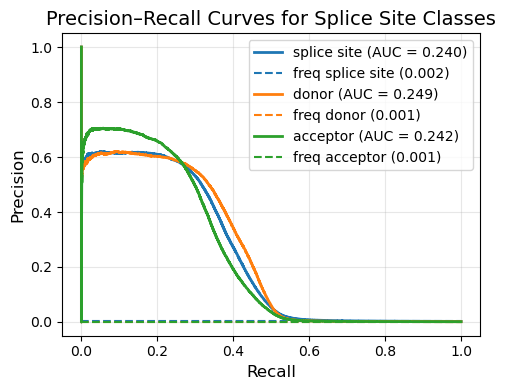

PR-AUC for splice site: 0.2401
PR-AUC for donor: 0.2488
PR-AUC for acceptor: 0.2423


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

pr_auc_scores = {}
plt.figure(figsize=(5, 4))

class_labels = {0: 'splice site', 1: 'donor', 2: 'acceptor'}
class_colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green'}

total_positions = true_labels.shape[0] * true_labels.shape[1]

for class_idx in range(3):
    color = class_colors[class_idx]
    label = class_labels[class_idx]
    if class_idx == 0:
        y_true = (true_labels != class_idx).astype(int).reshape(-1)
        y_scores = 1 - pred_probs[:, :, class_idx].reshape(-1)
        freq = np.sum(true_labels != class_idx) / total_positions
    else:
        y_true = (true_labels == class_idx).astype(int).reshape(-1)
        y_scores = pred_probs[:, :, class_idx].reshape(-1)
        freq = np.sum(true_labels == class_idx) / total_positions

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    pr_auc_scores[class_idx] = pr_auc

    plt.plot(
        recall, precision,
        label=f"{label} (AUC = {pr_auc:.3f})",
        linewidth=2,
        color=color
    )
    plt.hlines(
        y=freq, xmin=0, xmax=1,
        colors=color, linestyles='dashed',
        label=f'freq {label} ({freq:.3f})'
    )

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision–Recall Curves for Splice Site Classes", fontsize=14)
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("plots/pr_curves_splicevo.pdf", dpi=300)
plt.show()

for c, auc_score in pr_auc_scores.items():
    print(f"PR-AUC for {class_labels[c]}: {auc_score:.4f}")


Calculate top-k accuracy by choosing a threshold to make predicted positive sites and actual positive sites have the same number, then computing the fraction of correctly predicted splice sites.

In [9]:
def top_k_accuracy(y_true, y_scores):
    # How many actual positive sites (k) are there?
    k = np.sum(y_true)
    # Select prediction value threshold at which there are k predicted positive sites
    threshold = np.sort(y_scores)[-k]
    # Predicted positive sites
    y_pred = (y_scores >= threshold).astype(int)
    # Calculate accuracy
    accuracy = np.sum((y_pred == 1) & (y_true == 1)) / k
    return accuracy

top_k_acc = {}
for class_idx in range(3):
    if class_idx == 0:
        y_true = (true_labels != class_idx).astype(int)
        y_scores = 1 - pred_probs[:, :, class_idx].reshape(-1)
    else:
        y_true = (true_labels == class_idx).astype(int)
        y_scores = pred_probs[:,:,class_idx]
    y_true = y_true.reshape(-1)
    y_scores = y_scores.reshape(-1)
    acc = top_k_accuracy(y_true, y_scores)
    top_k_acc[class_idx] = acc
    print(f"Top-k accuracy for class {class_idx}: {acc:.4f}")

Top-k accuracy for class 0: 0.3668
Top-k accuracy for class 1: 0.3843
Top-k accuracy for class 2: 0.3449


Splice usage prediction performance on the test data.

In [10]:
# Calculate the mean squared error for each tissue and timepoint
from sklearn.metrics import mean_squared_error
mse_dict = {}
for i in range(len(conds)):
    id = conds[i]
    true_sse_ = true_sse[:, :, i-1]
    pred_sse_ = pred_sse[:, :, i-1]
    # Replace NaN values in true_sse_ with 0
    true_sse_ = np.nan_to_num(true_sse_)
    # Select non-NaN values
    mask = ~np.isnan(true_sse_)
    true_sse_vals = true_sse_[mask]
    pred_sse_vals = pred_sse_[mask]
    mse = mean_squared_error(true_sse_vals, pred_sse_vals)
    mse_dict[id] = mse

# Make a dataframe: species, tissue, timepoint, mse
mse_df = pd.DataFrame(list(mse_dict.items()), columns=['Sample', 'MSE'])
mse_df[['Tissue', 'Timepoint']] = mse_df['Sample'].str.split('_', expand=True)
mse_df

,Sample,MSE,Tissue,Timepoint
0,Brain_1,0.116262,Brain,1
1,Brain_4,0.143873,Brain,4
2,Brain_5,0.143466,Brain,5
3,Brain_7,0.116236,Brain,7
4,Brain_9,0.122117,Brain,9
5,Brain_10,0.139727,Brain,10
6,Brain_14,0.105485,Brain,14


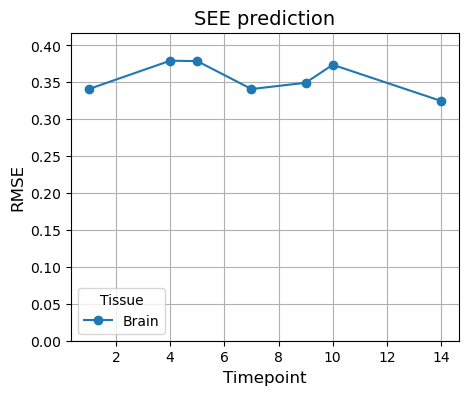

In [11]:
import numpy as np

import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
for tissue in mse_df['Tissue'].unique():
    tissue_data = mse_df[mse_df['Tissue'] == tissue]
    plt.plot(
        tissue_data['Timepoint'].astype(int),
        np.sqrt(tissue_data['MSE']),
        marker='o',
        label=tissue
    )
plt.title('SEE prediction', fontsize=14)
plt.xlabel('Timepoint', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.ylim(0, np.sqrt(mse_df['MSE']).max() * 1.1)
plt.legend(title='Tissue')
plt.grid()
plt.show()


Select interesting example to show

In [12]:
# For every sequence, identify positions that are not NaN in all tissues, then compare values
num_sequences = true_sse.shape[0]
num_positions = true_sse.shape[1]
num_tissues = true_sse.shape[2]

matched_positions = {}

for seq_idx in range(num_sequences):
    # Find positions where all tissues are not NaN for this sequence
    valid_positions = np.where(np.all(~np.isnan(true_sse[seq_idx, :, :]), axis=1))[0]
    # Find positions where at least one tissue is not NaN for this sequence
    # valid_positions = np.where(np.any(~np.isnan(true_sse[seq_idx, :, :]), axis=1))[0]
    if len(valid_positions) == 0:
        continue
    for pos in valid_positions:
        true_vals = true_sse[seq_idx, pos, :]
        pred_vals = pred_sse[seq_idx, pos, :]
        true_vals = np.nan_to_num(true_vals)
        matched_positions[(seq_idx, pos)] = { "true": true_vals, "pred": pred_vals }

# Combine all matched positions into a single dataframe for plotting
import pandas as pd
all_data = []
for (seq_idx, pos), vals in matched_positions.items():
    for tissue_idx in range(num_tissues):
        all_data.append({
            'sequence': seq_idx,
            'position': pos,
            'group': conds[tissue_idx],
            'true_SSE': vals['true'][tissue_idx],
            'pred_SSE': vals['pred'][tissue_idx]
        })  

all_data_df = pd.DataFrame(all_data)
all_data_df

,sequence,position,group,true_SSE,pred_SSE
0,7,574,Brain_1,0.786,0.668660
1,7,574,Brain_4,0.381,0.678624
2,7,574,Brain_5,0.636,0.616516
3,7,574,Brain_7,0.000,0.556747
4,7,574,Brain_9,0.000,0.652527
...,...,...,...,...,...
377176,54039,607,Brain_5,0.841,0.079574
377177,54039,607,Brain_7,0.952,0.081210
377178,54039,607,Brain_9,0.922,0.097204
377179,54039,607,Brain_10,0.975,0.077799


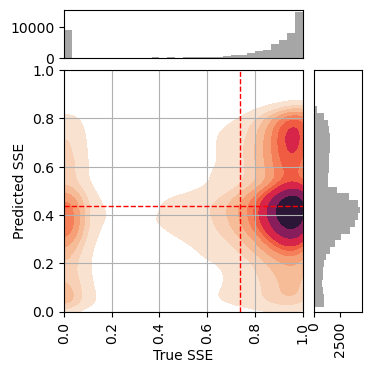

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

samples = all_data_df['group'].unique()[0:1] # Only one timepoint
axes = {}
num_tissues = len(samples)
num_cols = 1
num_rows = (num_tissues + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4), squeeze=False)

for i, tissue in enumerate(samples):
    tissue_data = all_data_df[all_data_df['group'] == tissue]

    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]

    # Scatter plot
    #ax.scatter(
    #    tissue_data['true_SSE'],
    #    tissue_data['pred_SSE'],
    #    alpha=0.2,
    #    s=4
    #)

    # 2d density plot
    sns.kdeplot(
        x=tissue_data['true_SSE'],
        y=tissue_data['pred_SSE'],
        levels=10,
        fill = True,
        cmap="rocket_r",
        ax=ax
    )

    # Top histogram (True SSE)
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
    ax_histx.hist(
        tissue_data['true_SSE'],
        bins=30,
        color='gray',
        alpha=0.7
    )
    ax_histx.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

    # Right histogram (Pred SSE)
    ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)
    ax_histy.hist(
        tissue_data['pred_SSE'],
        bins=30,
        orientation='horizontal',
        color='gray',
        alpha=0.7
    )
    ax_histy.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)

    plt.setp(ax_histy.get_xticklabels(), rotation=90, ha='center')
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center')

    ax_histy.set_xlabel('')
    ax_histx.set_xlabel('')
    ax_histy.set_ylabel('')

    # Add mean lines
    mean_true = tissue_data['true_SSE'].mean()
    mean_pred = tissue_data['pred_SSE'].mean()
    ax.axvline(mean_true, color='red', linestyle='--', linewidth=1, label='Mean True')
    ax.axhline(mean_pred, color='red', linestyle='--', linewidth=1, label='Mean Pred')

    #ax.set_title(f'{tissue}', fontsize=10)
    ax.set_xlabel('True SSE', fontsize=10)
    ax.set_ylabel('Predicted SSE', fontsize=10)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid()

plt.tight_layout()
plt.savefig("plots/SSE_predicted_vs_true_scatter_brain.pdf", dpi=300)


In [14]:
# Group by sequence and position, and calculate correlation between true and predicted SSE values
correlation_results = []
for (seq_idx, pos), group in all_data_df.groupby(['sequence', 'position']):
    true_vals = group['true_SSE'].values
    pred_vals = group['pred_SSE'].values
    if len(true_vals) < 2:
        continue
    correlation = np.corrcoef(true_vals, pred_vals)[0, 1]
    correlation_results.append({
        'sequence': seq_idx,
        'position': pos,
        'correlation': correlation
    })

correlation_df = pd.DataFrame(correlation_results)
correlation_df.sort_values(by='correlation', ascending=False)

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,sequence,position,correlation
29592,28274,263,0.992754
8403,7953,41,0.979481
3536,3046,487,0.978843
51282,51588,0,0.975456
17726,17394,257,0.975118
...,...,...,...
53367,53567,566,NaN
53551,53748,632,NaN
53615,53803,834,NaN
53738,53938,842,NaN


In [15]:
# How many are NaN?
nas = correlation_df['correlation'].isna()
print(
    f"{nas.sum()} ({nas.mean() * 100:.2f}%) of the correlation values are NaN."
)

2026 (3.76%) of the correlation values are NaN.


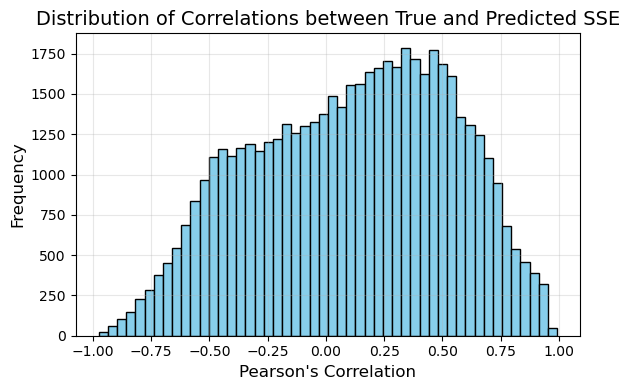

In [16]:
# Plot distribution of correlations
plt.figure(figsize=(6, 4))
plt.hist(correlation_df['correlation'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Correlations between True and Predicted SSE', fontsize=14)
plt.xlabel("Pearson's Correlation", fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('plots/SSE_correlation_distribution_brain.pdf', bbox_inches='tight')
plt.show()

In [17]:
top_examples = correlation_df.sort_values(by='correlation', ascending=False)[0:8]
top_examples

,sequence,position,correlation
29592,28274,263,0.992754
8403,7953,41,0.979481
3536,3046,487,0.978843
51282,51588,0,0.975456
17726,17394,257,0.975118
46071,46110,646,0.974239
13208,12253,817,0.974109
4489,4103,110,0.973412


In [18]:
plot_df = all_data_df[(all_data_df['sequence'].isin(top_examples['sequence'])) & (all_data_df['position'].isin(top_examples['position']))]
plot_df['site'] = plot_df['sequence'].astype(str) + '_' + plot_df['position'].astype(str)
plot_df['tissue'] = plot_df['group'].apply(lambda x: x.split('_')[0])
plot_df['timepoint'] = plot_df['group'].apply(lambda x: x.split('_')[1])
plot_df

/tmp/ipykernel_902828/3557751785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['site'] = plot_df['sequence'].astype(str) + '_' + plot_df['position'].astype(str)
/tmp/ipykernel_902828/3557751785.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['tissue'] = plot_df['group'].apply(lambda x: x.split('_')[0])
/tmp/ipykernel_902828/3557751785.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

,sequence,position,group,true_SSE,pred_SSE,site,tissue,timepoint
24752,3046,487,Brain_1,0.988,0.704367,3046_487,Brain,1
24753,3046,487,Brain_4,0.982,0.677770,3046_487,Brain,4
24754,3046,487,Brain_5,0.969,0.637800,3046_487,Brain,5
24755,3046,487,Brain_7,0.979,0.681924,3046_487,Brain,7
24756,3046,487,Brain_9,0.973,0.675065,3046_487,Brain,9
24757,3046,487,Brain_10,0.950,0.594623,3046_487,Brain,10
24758,3046,487,Brain_14,0.944,0.590202,3046_487,Brain,14
31423,4103,110,Brain_1,1.000,0.783428,4103_110,Brain,1
31424,4103,110,Brain_4,1.000,0.761640,4103_110,Brain,4
31425,4103,110,Brain_5,0.923,0.719853,4103_110,Brain,5


/tmp/ipykernel_902828/3535911259.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['timepoint'] = pd.Categorical(plot_df['timepoint'], categories=timepoint_order, ordered=True)


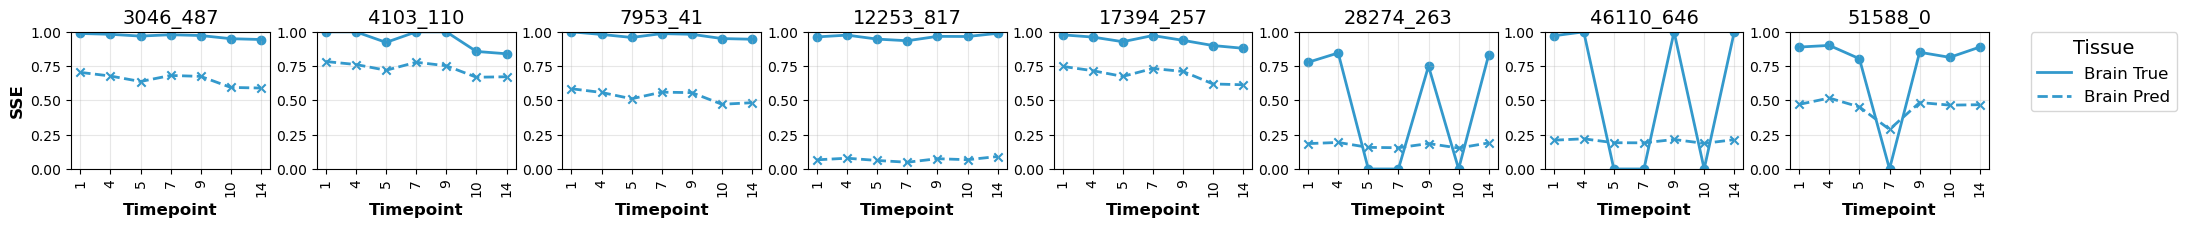

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline

# Define tissue colors
tissue_colors = {
    'Brain': '#3399cc',
    'Cerebellum': '#34ccff',
    'Heart': '#cc0100',
    'Kidney': '#cc9900',
    'Liver': '#339900',
    'Ovary': '#cc329a',
    'Testis': '#ff6600'
}

unique_sites = plot_df['site'].unique()
smooth = False

timepoint_order = sorted(plot_df['timepoint'].unique(), key=lambda x: int(''.join(filter(str.isdigit, x))))
plot_df['timepoint'] = pd.Categorical(plot_df['timepoint'], categories=timepoint_order, ordered=True)

n_sites = len(unique_sites)
n_tissues = len(plot_df['tissue'].unique())
fig, axes = plt.subplots(n_tissues, n_sites, figsize=(2.5 * n_sites, 2.5 * n_tissues), sharex='col')

if n_sites == 1 and n_tissues == 1:
    axes = axes.reshape(1, 1)
elif n_sites == 1:
    axes = axes.reshape(n_tissues, 1)
elif n_tissues == 1:
    axes = axes.reshape(1, n_sites)

legend_handles, legend_labels = [], []

for col_idx, site in enumerate(unique_sites):
    site_data = plot_df[plot_df['site'] == site]
    for tissue in site_data['tissue'].unique():
        row_idx = list(plot_df['tissue'].unique()).index(tissue)
        tissue_data = site_data[site_data['tissue'] == tissue].sort_values('timepoint')
        color = tissue_colors.get(tissue, '#000000')
        x_values = tissue_data['timepoint'].cat.codes
        y_sse_true = tissue_data['true_SSE'].values
        y_sse_pred = tissue_data['pred_SSE'].values

        def smooth_spline(x, y):
            if smooth and len(x) > 3:
                x_dense = np.linspace(x.min(), x.max(), 100)
                if len(np.unique(x)) < 4:
                    return x, y
                spline = make_interp_spline(x, y, k=2)
                y_smooth = spline(x_dense)
                return x_dense, y_smooth
            else:
                return x, y

        # True SSE: solid line
        x_sse, y_sse_true_smooth = smooth_spline(x_values, y_sse_true)
        line_true, = axes[row_idx, col_idx].plot(x_sse, y_sse_true_smooth, label=f'{tissue} True', color=color, linewidth=2, linestyle='-')
        axes[row_idx, col_idx].scatter(x_values, y_sse_true, color=color, marker='o', s=36)

        # Predicted SSE: dashed line
        x_sse, y_sse_pred_smooth = smooth_spline(x_values, y_sse_pred)
        line_pred, = axes[row_idx, col_idx].plot(x_sse, y_sse_pred_smooth, label=f'{tissue} Pred', color=color, linewidth=2, linestyle='--')
        axes[row_idx, col_idx].scatter(x_values, y_sse_pred, color=color, marker='x', s=36)

        if col_idx == 0:
            legend_handles.extend([line_true, line_pred])
            legend_labels.extend([f'{tissue} True', f'{tissue} Pred'])

        axes[row_idx, col_idx].set_ylim(0, 1)
        axes[row_idx, col_idx].set_title(f'{site}', fontsize=14)
        axes[row_idx, col_idx].set_xlabel('Timepoint', fontsize=12, fontweight='bold')
        axes[row_idx, col_idx].set_xticks(range(len(timepoint_order)))
        axes[row_idx, col_idx].set_xticklabels(timepoint_order, rotation=90)
        axes[row_idx, col_idx].grid(True, alpha=0.3)

axes[0, 0].set_ylabel('SSE', fontsize=12, fontweight='bold')

fig.legend(legend_handles, legend_labels, loc='lower center', bbox_to_anchor=(1.05, 0.5),
           title='Tissue', title_fontsize=14, fontsize=12, ncol=1)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('plots/SSE_prediction_top_examples_brain.pdf', bbox_inches='tight')
plt.show()
